In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from sklearn.metrics import mean_squared_error
from math import sqrt

Start by looking at the data

In [2]:
ts = pd.read_csv("OutputFile.csv")

In [3]:
ts.head()

,Variables,1985 Jan,1985 Feb,1985 Mar,1985 Apr,1985 May,1985 Jun,1985 Jul,1985 Aug,1985 Sep,...,2017 Oct,2017 Nov,2017 Dec,2018 Jan,2018 Feb,2018 Mar,2018 Apr,2018 May,2018 Jun,2018 Jul
0,Total,32.7,32,27.3,22.3,23.5,21.4,21.7,22.7,21.7,...,97.7,101.7,119.4,102.9,96.1,99.6,93.4,99.3,101.1,96.1
1,Department Stores,na,na,na,na,na,na,na,na,na,...,97.8,103.9,134.3,108.4,103.9,99.0,87.3,99.3,93.2,91.6
2,Supermarkets & Hypermarkets,na,na,na,na,na,na,na,na,na,...,99.3,93.5,102.8,106.0,110.1,96.5,95.0,100.0,94.8,97.7
3,Mini-marts & Convenience Stores,48.8,66.4,46.1,46.6,47.1,42.3,46.7,50.4,47.7,...,100.5,95.4,97.0,105.0,96.8,99.9,99.4,100.6,98.0,100.2
4,Food Retailers,na,na,na,na,na,na,na,na,na,...,98.7,99.7,111.4,106.7,134.5,100.8,93.0,96.8,88.7,97.2


In [4]:
ts = ts.set_index(ts[' Variables '])

In [5]:
ts = ts.drop(' Variables ', axis=1)

In [6]:
ts = ts.transpose()

In [7]:
ts = ts[" Total "]

In [8]:
ts = ts.apply(float)

In [9]:
ts.index = pd.to_datetime(ts.index, format=" %Y %b ")

In [10]:
ts.index = pd.DatetimeIndex(ts.index,freq=ts.index.inferred_freq)

In [11]:
ts.head()

1985-01-01    32.7
1985-02-01    32.0
1985-03-01    27.3
1985-04-01    22.3
1985-05-01    23.5
Freq: MS, Name:  Total , dtype: float64

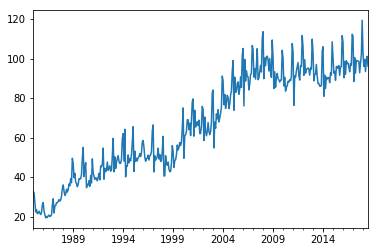

In [12]:
ts.plot()

In [14]:
train = ts.loc[:'2014-12-01']
test = ts.loc['2015-01-01':]
assert train.shape[0] + test.shape[0] == ts.shape[0]

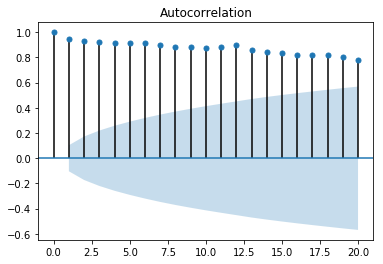

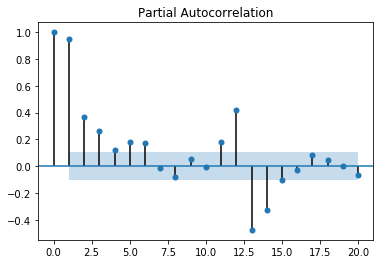

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train, lags=20)
plot_pacf(train, lags=20)
plt.show()

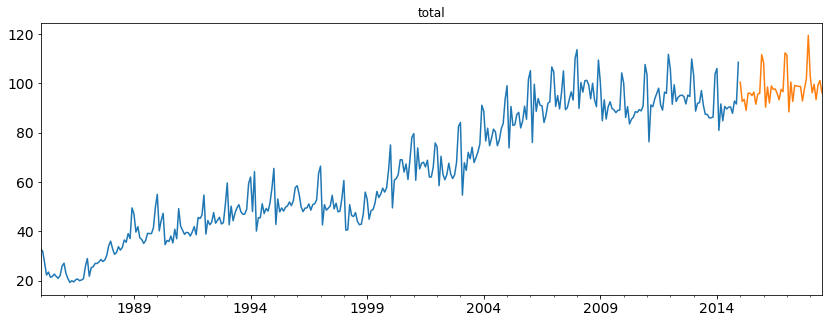

In [16]:
train.plot(figsize=(14,5), title= 'total', fontsize=14)
test.plot(figsize=(14,5), title= 'total', fontsize=14)
plt.show()

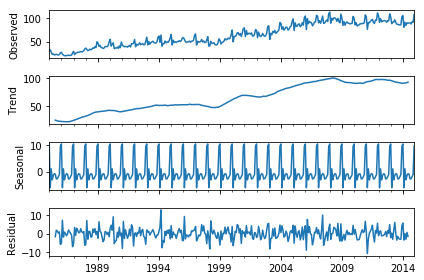

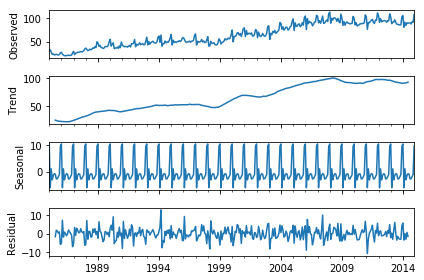

In [17]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train).plot()
# result = sm.tsa.stattools.adfuller(train)
# plt.show()

In [18]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### Try Double Exponential Smoothing (Trend=Yes, Seasonality=No)

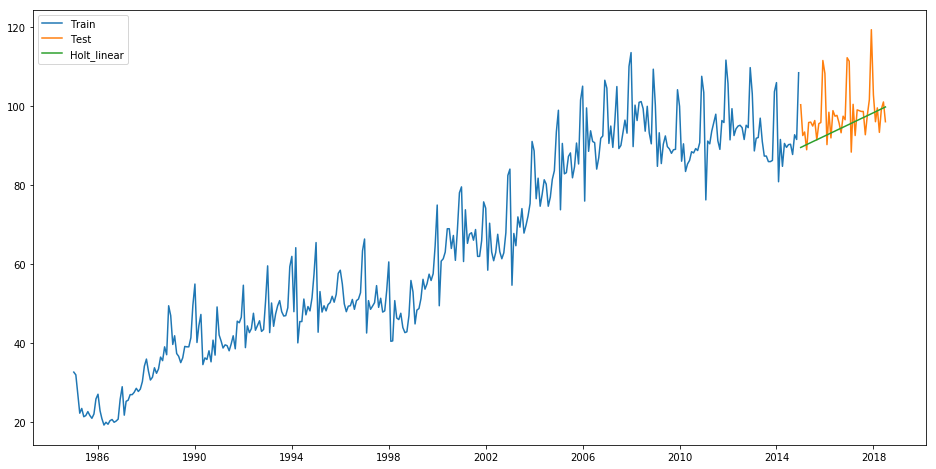

root_mean_squared_error: 7.176818


In [19]:
fit1 = Holt(np.asarray(train)).fit(smoothing_level = 0.1,smoothing_slope = 0.2)
y_hat = fit1.forecast(len(test))
y_hat = pd.Series(y_hat, index=test.index)
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat, label='Holt_linear')
plt.legend(loc='best')
plt.show()
print("root_mean_squared_error: %f"% sqrt(mean_squared_error(test,y_hat)))

### Try Triple Exponential Smoothing (Trend=Yes, Seasonality=Yes)

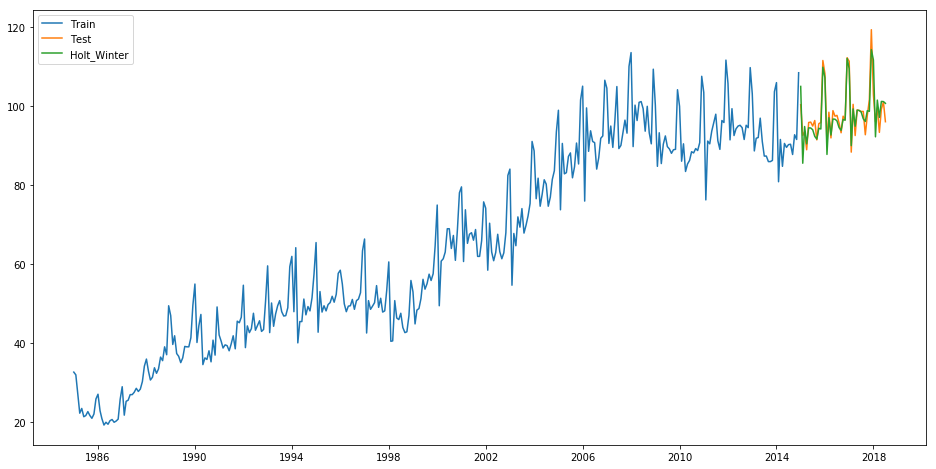

root_mean_squared_error: 2.736674


In [20]:
fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
y_hat = fit1.forecast(len(test))
y_hat = pd.Series(y_hat, index=test.index)
plt.figure(figsize=(16,8))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat, label='Holt_Winter')
plt.legend(loc='best')
plt.show()
print("root_mean_squared_error: %f"% sqrt(mean_squared_error(test,y_hat)))

### SARIMA[P,D,Q][p,d,q][s]

/Users/Nikolas/anaconda/envs/main/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


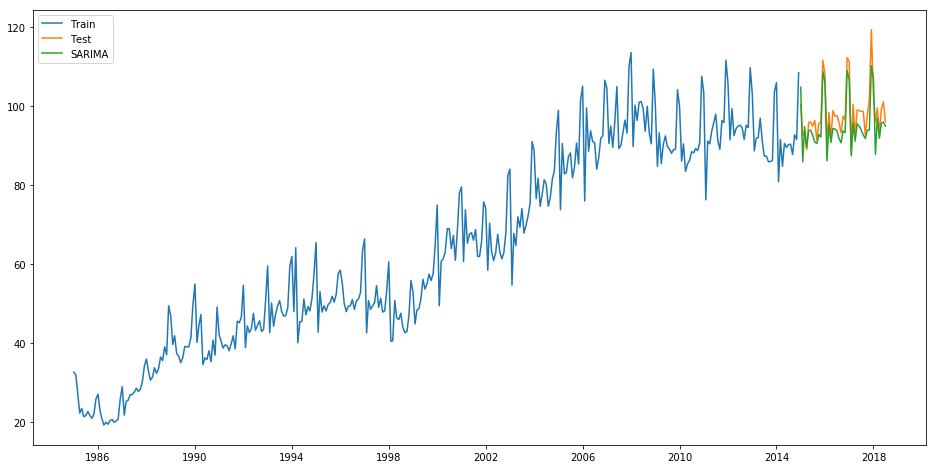

root_mean_squared_error: 4.034610


In [21]:
fit1 = sm.tsa.statespace.SARIMAX(endog=train, order=(2, 1, 4),seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit()
y_hat = fit1.predict(start="2015-01-1", end="2018-07-01", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat, label='SARIMA')
plt.legend(loc='best')
plt.show()
print("root_mean_squared_error: %f"% sqrt(mean_squared_error(test,y_hat)))

### Fit entire train set and make forecast

In [22]:
fit_final = ExponentialSmoothing(np.asarray(pd.concat([train,test],axis=0)) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()

In [23]:
y_hat = fit_final.forecast(1)
print(y_hat)

[ 97.41049864]


### Try Prophet

In [24]:
from fbprophet import Prophet

In [25]:
train_df = pd.DataFrame()
train_df["ds"] = train.index
train_df["y"] = train.values

test_df = pd.DataFrame()
test_df["ds"] = test.index
test_df["y"] = test.values

In [26]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
future = m.make_future_dataframe(periods=test_df.shape[0], freq="m")

In [28]:
forecast = m.predict(future)

In [29]:
yhat = forecast[["ds","yhat"]]

In [30]:
yhat.index = yhat.ds

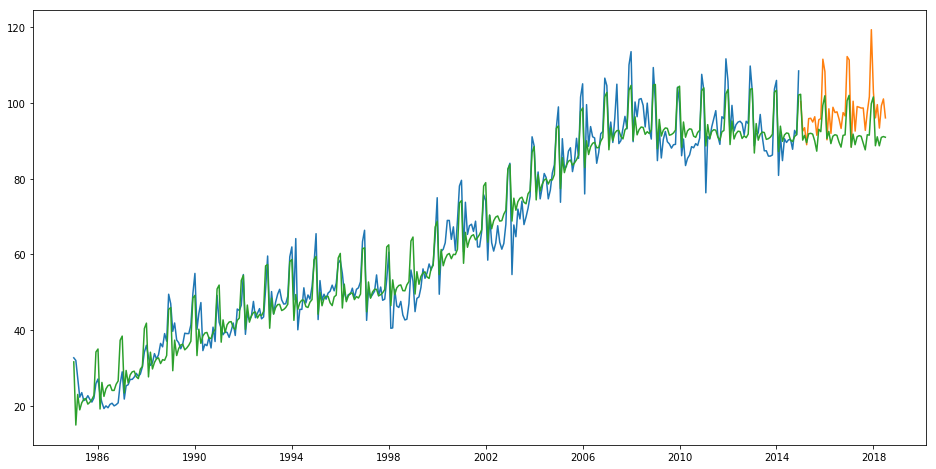

root_mean_squared_error: 6.968074


In [31]:
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Train')
plt.plot(yhat.yhat, label='Test')
plt.show()
print("root_mean_squared_error: %f"% sqrt(mean_squared_error(test,yhat.yhat[-test.size:])))